In [1]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import multivariate_normal, norm
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.optim as optim

In [3]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
#assert pyro.__version__.startswith('1.8.5')

http://pyro.ai/examples/bayesian_regression.html

In [4]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness



In [5]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")


In [6]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)



In [7]:
from pyro.infer import SVI, Trace_ELBO


svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5795.468078792095
Elbo loss: 415.8169758319855
Elbo loss: 250.71917808055878
Elbo loss: 247.19455778598785
Elbo loss: 249.20037311315536
Elbo loss: 250.96487379074097
Elbo loss: 249.35092586278915
Elbo loss: 248.78312557935715
Elbo loss: 248.62142211198807
Elbo loss: 250.42745852470398


In [112]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}


In [113]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean


guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model,
          guide,
          optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))


Elbo loss: 685.7096581459045
Elbo loss: 436.24905240535736
Elbo loss: 260.48608434200287
Elbo loss: 247.7645760178566
Elbo loss: 247.15567445755005
Elbo loss: 248.10909110307693
Elbo loss: 247.97296398878098
Elbo loss: 248.24592864513397
Elbo loss: 248.39307969808578
Elbo loss: 249.24443620443344


In [123]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}


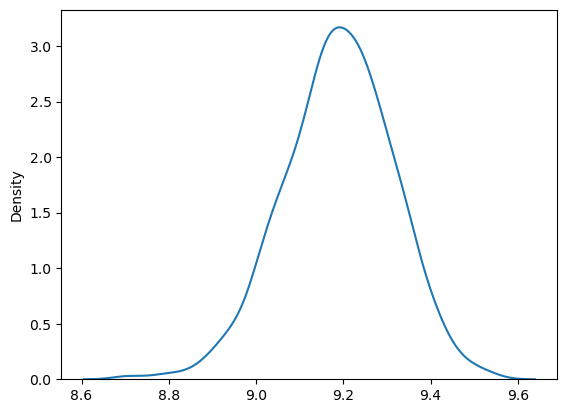

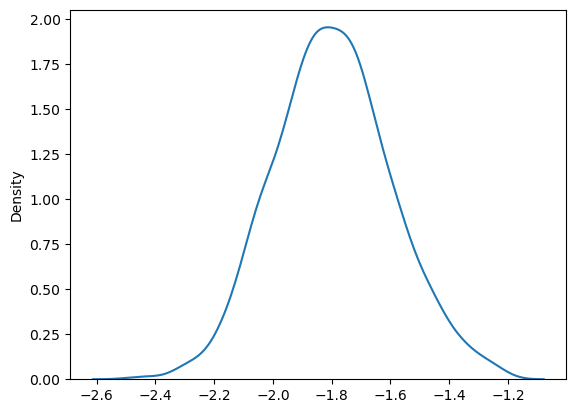

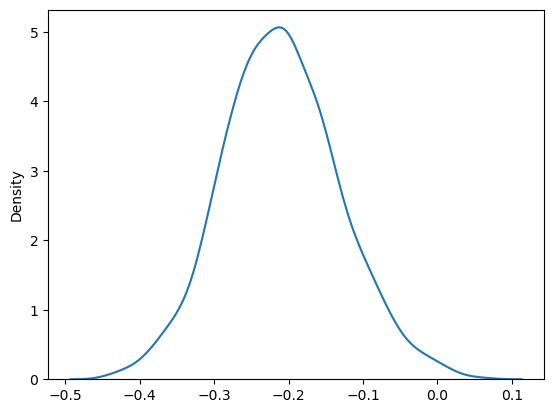

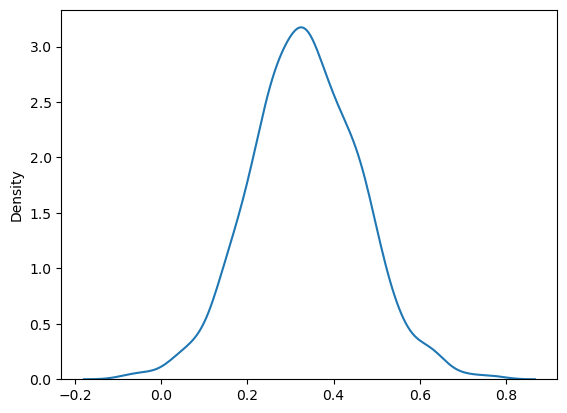

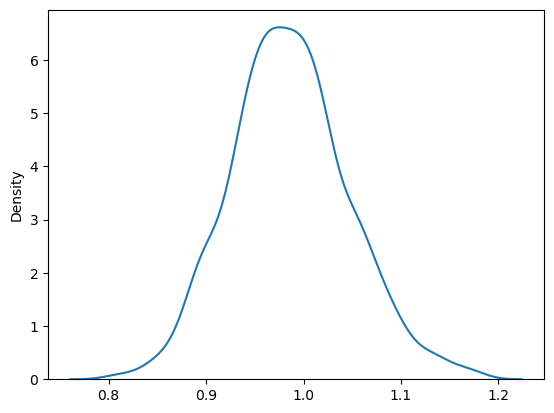

In [124]:
for k in svi_samples.keys():
    fig, axes = plt.subplots()
    sns.kdeplot(svi_samples[k], ax = axes)

In [216]:
x = np.random.random(200)

mean_r = np.random.gamma(1, size = 200)
std_r = np.random.gamma(2, size = 200)

data = np.array([np.random.gamma(mean + xi, std) for mean, std, xi in zip(mean_r, std_r, x)])

x, data = torch.Tensor(x), torch.Tensor(data)

<AxesSubplot:ylabel='Density'>

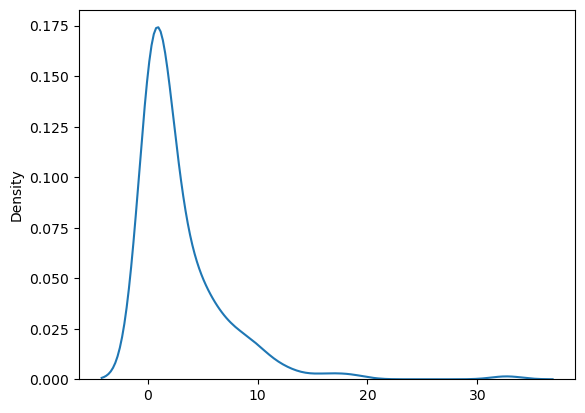

In [217]:
sns.kdeplot(data)

In [228]:
def model(x, data):
    n = len(x)

    with pyro.plate("data", n):
        alpha = pyro.sample("alpha", dist.Gamma(1, 1))
        beta = pyro.sample("beta", dist.Gamma(2, 1))
        alpha1 = x + alpha

        y = pyro.sample("obs", dist.Gamma(alpha1, beta), obs = data)

In [224]:
alpha, beta, n = model(x, data)


In [267]:
torch.distributions.gamma.Gamma(1, 2)

Gamma(concentration: 1.0, rate: 2.0)

In [274]:
def guide(x, data):
    k1_loc = pyro.param("k1_loc", 5. * torch.ones(200), constraint = constraints.positive)
    k1_scale = pyro.param("k1_scale", 5. * torch.ones(200), constraint = constraints.positive)
    k2_loc = pyro.param("k2_loc", 5. * torch.ones(200), constraint = constraints.positive)
    k2_scale = pyro.param("k2_scale", 5. * torch.ones(200), constraint = constraints.positive)
    
    k1 = pyro.param("k1", torch.distributions.gamma.Gamma(k1_loc, k1_scale), constraint = constraints.positive)
    k2 = pyro.param("k2", torch.distributions.gamma.Gamma(k2_loc, k2_scale), constraint = constraints.positive)
    
    n = len(x)
    with pyro.plate("data", n):

        alpha = pyro.sample("alpha", dist.Gamma(k1, 1))
        beta = pyro.sample("beta", dist.Gamma(k2, 1))

        alpha1 = x + alpha

In [275]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .01}),
          loss=Trace_ELBO())


In [276]:
for i in range(num_iters):
    elbo = svi.step(x, data)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))


ValueError: Expected parameter concentration (Tensor of shape (200,)) of distribution Gamma(concentration: torch.Size([200]), rate: torch.Size([200])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([     nan,      nan,  12.9120,  52.7184, 117.7308, 124.9569,  75.1748,
          3.5101,      nan,   8.6250, 137.0323,  68.2716,   2.6960,      nan,
         81.0381,      nan,  24.9522,   1.7273,  62.2101,  68.4529,  31.2078,
          4.6110,  21.6327, 112.8807,  19.3254,      nan,  40.5033,  32.8656,
             nan,  12.5674,  99.8973,  34.6076, 155.6414,  33.1006,  81.7448,
         31.8296,      nan,  48.5815,  19.1919,  80.6823,  56.5880, 121.0973,
         38.1781,  19.8260,  22.8100,  54.2079,   8.8789,      nan,      nan,
             nan,  63.8546,      nan,  40.6886,  45.9080,      nan,   9.9686,
         71.6771,  74.0522,  94.3944,   5.7834,  28.3152,  36.1552,  38.0414,
             nan,  69.6795,   6.7604,      nan,  50.1965,  13.9214,  55.1521,
         30.0322,   9.6001,  56.3909,  99.3652,      nan,  47.6199,   3.5196,
          4.0780,  27.2935,  41.3318,  31.4874,   2.3760,  62.1409,  74.0673,
         49.6208,  13.7399,      nan,      nan,  52.1778,  37.3500, 115.3228,
         53.1331,      nan,      nan, 134.8598,      nan,  33.0239,      nan,
             nan,  43.5198,  48.5685,      nan,  11.7074, 147.3792,      nan,
         63.9782,  33.8666, 101.2754,  27.2823,      nan,  27.5845,      nan,
         49.3790,  47.0907,      nan,      nan,  68.2973,      nan,  21.1678,
         73.6841,  83.5137,      nan, 106.3971,      nan, 137.2092,      nan,
         53.4877, 161.7221, 110.3617,  63.5042, 148.4861,  13.9181,  76.6939,
         16.5846,      nan,  75.0655,  71.9761,      nan,      nan,  44.4735,
        167.0105,  51.4162,  23.9224,  68.9769,  44.5167,      nan,  81.8453,
             nan,      nan,  75.2183,  76.9477,  30.4591,      nan,  65.3557,
         61.0804,  37.4619,      nan,  62.9589, 119.8534,  21.4216,  27.3038,
         60.9180,  48.3625,  44.6018,  83.0253,      nan,  54.4871,   6.9534,
        124.7420,  36.8593,      nan, 105.5137,   5.1331,      nan,  41.3915,
         20.8033,      nan,      nan,  48.9067,      nan,  56.3892,  71.3802,
             nan, 110.4605,      nan,  84.1188,   1.6779,  75.8580,  50.5456,
        100.4443,      nan,  51.9371,  67.1192,      nan,  51.0213,  55.2740,
        150.2390,  58.1334,  24.8933,      nan], grad_fn=<AddBackward0>)
Trace Shapes:        
 Param Sites:        
       k1_loc        
     k1_scale        
       k2_loc        
     k2_scale        
           k1     200
           k2     200
Sample Sites:        
    data dist       |
        value 200   |

In [244]:
elbo

896.5263366699219

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
